In [1]:

!pip install numpy pandas matplotlib seaborn torch gymnasium scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 9.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 11.5 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 11.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 11.2 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.1/951.1 kB 11.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 11.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 11.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 10.1 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 11.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 9.9 MB/s 

In [2]:
# =============================================================================
# CELL 2: Import Required Libraries
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

Matplotlib is building the font cache; this may take a moment.


In [3]:
# =============================================================================
# CELL 3: Generate Synthetic Loan Application Data
# =============================================================================

def generate_loan_data(n_samples=10000):
    """
    Generate synthetic loan application data with realistic distributions
    """
    np.random.seed(42)

    # Generate features
    data = {
        'income': np.random.gamma(shape=2, scale=30000, size=n_samples),
        'credit_score': np.random.normal(loc=650, scale=100, size=n_samples).clip(300, 850),
        'employment_length': np.random.exponential(scale=5, size=n_samples).clip(0, 40),
        'debt_to_income': np.random.beta(a=2, b=5, size=n_samples) * 0.6,
        'loan_amount': np.random.gamma(shape=2, scale=15000, size=n_samples),
        'age': np.random.normal(loc=40, scale=12, size=n_samples).clip(18, 80),
        'num_credit_lines': np.random.poisson(lam=5, size=n_samples).clip(0, 20),
        'credit_history_length': np.random.exponential(scale=8, size=n_samples).clip(0, 40),
    }

    df = pd.DataFrame(data)

    # Calculate default probability based on risk factors
    # FIXED: Adjusted to produce realistic default rate (15-20% instead of 45%)
    risk_score = (
        (df['credit_score'] - 300) / 550 * 0.35 +
        (df['income'] / 100000) * 0.30 +
        (1 - df['debt_to_income']) * 0.25 +
        (df['employment_length'] / 40) * 0.05 +
        (df['credit_history_length'] / 40) * 0.05
    )

    # Default probability (inverse of risk score with adjustment for realistic rates)
    base_default_prob = 1 - risk_score.clip(0, 1)
    # Scale down to achieve ~15-20% default rate
    df['default_probability'] = (base_default_prob * 0.35).clip(0, 0.95)

    # Generate actual default outcomes
    df['defaults'] = (np.random.random(n_samples) < df['default_probability']).astype(int)

    return df

# Generate data
loan_data = generate_loan_data(10000)
print(f"Generated {len(loan_data)} loan applications")
print(f"\nDefault rate: {loan_data['defaults'].mean():.2%}")
print("\nFirst few rows:")
print(loan_data.head())
print("\nData statistics:")
print(loan_data.describe())

Generated 10000 loan applications

Default rate: 13.59%

First few rows:
          income  credit_score  employment_length  debt_to_income  \
0   71810.381696    512.560075           1.704060        0.302520   
1   44833.941906    783.013331           1.983329        0.083576   
2   41468.507531    700.997474           7.309342        0.155662   
3   41469.068830    807.029551           0.951041        0.044694   
4  139491.432367    404.033285           2.404601        0.269741   

    loan_amount        age  num_credit_lines  credit_history_length  \
0  16312.139587  52.432107                11              35.013291   
1  31766.095071  41.240180                 2               2.960015   
2  16276.080092  31.896098                 3               5.259030   
3  29529.685744  34.395958                 2               5.379086   
4   9313.851344  57.907328                 5               5.729206   

   default_probability  defaults  
0             0.150163         1  
1             0

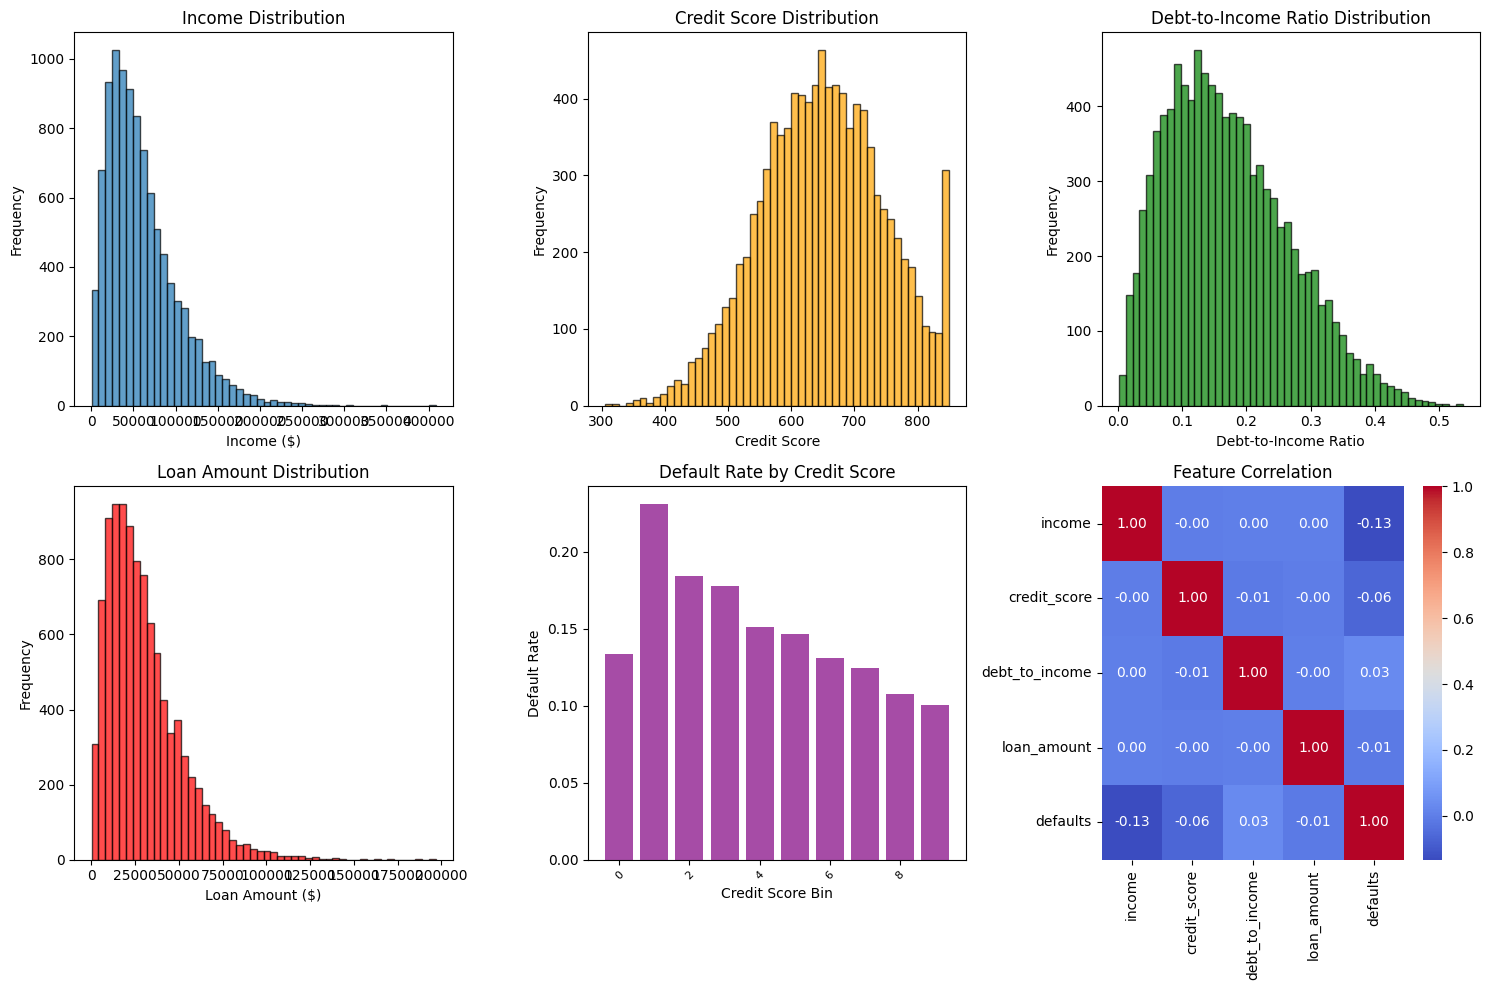

In [4]:
# =============================================================================
# CELL 4: Data Visualization
# =============================================================================

# Visualize the data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Income distribution
axes[0, 0].hist(loan_data['income'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Income Distribution')
axes[0, 0].set_xlabel('Income ($)')
axes[0, 0].set_ylabel('Frequency')

# Credit score distribution
axes[0, 1].hist(loan_data['credit_score'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Credit Score Distribution')
axes[0, 1].set_xlabel('Credit Score')
axes[0, 1].set_ylabel('Frequency')

# Debt to income ratio
axes[0, 2].hist(loan_data['debt_to_income'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 2].set_title('Debt-to-Income Ratio Distribution')
axes[0, 2].set_xlabel('Debt-to-Income Ratio')
axes[0, 2].set_ylabel('Frequency')

# Loan amount distribution
axes[1, 0].hist(loan_data['loan_amount'], bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1, 0].set_title('Loan Amount Distribution')
axes[1, 0].set_xlabel('Loan Amount ($)')
axes[1, 0].set_ylabel('Frequency')

# Default rate by credit score
loan_data['credit_score_bin'] = pd.cut(loan_data['credit_score'], bins=10)
default_by_credit = loan_data.groupby('credit_score_bin')['defaults'].mean()
axes[1, 1].bar(range(len(default_by_credit)), default_by_credit.values, alpha=0.7, color='purple')
axes[1, 1].set_title('Default Rate by Credit Score')
axes[1, 1].set_xlabel('Credit Score Bin')
axes[1, 1].set_ylabel('Default Rate')
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=8)

# Correlation heatmap
correlation_cols = ['income', 'credit_score', 'debt_to_income', 'loan_amount', 'defaults']
correlation = loan_data[correlation_cols].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 2])
axes[1, 2].set_title('Feature Correlation')

plt.tight_layout()
plt.show()

In [5]:
# =============================================================================
# CELL 5: Define the Loan Approval Environment (IMPROVED VERSION)
# =============================================================================
# Changes:
# - Action multipliers: [0.0, 0.5, 0.75, 1.0] for better balance
# - Reduced rejection rewards to discourage over-conservatism
# - Increased approval rewards to encourage profitable loans

class LoanApprovalEnvironment:
    """
    Custom environment for loan approval decisions

    State: [income, credit_score, employment_length, debt_to_income,
            loan_amount, age, num_credit_lines, credit_history_length]

    Actions:
        0: Reject loan (0%)
        1: Approve with half amount (50% of requested)
        2: Approve with reduced amount (75% of requested)
        3: Approve with full amount (100% of requested)

    Rewards:
        - Successful repayment: Higher profit reward
        - Default: Loss of loan amount
        - Rejection: Smaller opportunity cost
    """

    def __init__(self, loan_data):
        self.data = loan_data.copy()
        self.n_actions = 4
        self.n_features = 8
        self.current_idx = 0
        self.scaler = StandardScaler()

        # Fit scaler on all data
        feature_cols = ['income', 'credit_score', 'employment_length', 'debt_to_income',
                       'loan_amount', 'age', 'num_credit_lines', 'credit_history_length']
        self.data[feature_cols] = self.scaler.fit_transform(self.data[feature_cols])

        # Interest rate (annual)
        self.interest_rate = 0.15
        self.loan_term = 3  # years

        # Shuffle data
        self.data = self.data.sample(frac=1).reset_index(drop=True)

    def reset(self):
        """Reset to first applicant"""
        self.current_idx = 0
        return self._get_state()

    def _get_state(self):
        """Get current applicant's features"""
        if self.current_idx >= len(self.data):
            return None

        row = self.data.iloc[self.current_idx]
        state = np.array([
            row['income'],
            row['credit_score'],
            row['employment_length'],
            row['debt_to_income'],
            row['loan_amount'],
            row['age'],
            row['num_credit_lines'],
            row['credit_history_length']
        ], dtype=np.float32)

        return state

    def step(self, action):
        """
        Take an action and return next state, reward, done, info
        """
        row = self.data.iloc[self.current_idx]

        # Get actual loan amount (denormalize)
        loan_amount_idx = 4
        actual_loan_amount = row['loan_amount'] * self.scaler.scale_[loan_amount_idx] + \
                           self.scaler.mean_[loan_amount_idx]

        #Better balanced action multipliers
        action_multipliers = [0.0, 0.5, 0.75, 1.0]  # reject, 50%, 75%, 100%
        approved_amount = actual_loan_amount * action_multipliers[action]

        # Calculate reward
        reward = 0
        info = {}

        if action == 0:  # Reject
            # FIXED: Minimal penalty/reward to avoid over-conservatism
            if row['defaults'] == 0:
                reward = -5  # Small opportunity cost for rejecting good applicant
            else:
                reward = 2   # Small reward for correctly rejecting risky applicant
            info['decision'] = 'rejected'
            info['profit'] = 0

        else:  # Approve (with some amount)
            info['decision'] = 'approved'
            info['amount'] = approved_amount

            if row['defaults'] == 1:  # Default occurs
                # Lose the entire approved amount - this should hurt!
                reward = -approved_amount / 1000  # FIXED: Better scaling
                info['profit'] = -approved_amount
            else:  # Successful repayment
                # FIXED: Reward proportional to profit earned
                total_interest = approved_amount * self.interest_rate * self.loan_term
                reward = total_interest / 1000  # FIXED: Better scaling (profit matters more)
                info['profit'] = total_interest

        # Move to next applicant
        self.current_idx += 1
        done = self.current_idx >= len(self.data)
        next_state = self._get_state() if not done else None

        info['default'] = row['defaults']
        info['default_prob'] = row['default_probability']

        return next_state, reward, done, info

    def get_state_dim(self):
        return self.n_features

    def get_action_dim(self):
        return self.n_actions

In [6]:
# =============================================================================
# CELL 6: Test the Environment (IMPROVED VERSION)
# =============================================================================
# Updated to show new action names: [Reject, 50%, 75%, 100%]

# Test the environment
test_env = LoanApprovalEnvironment(loan_data)
state = test_env.reset()

print("Initial state shape:", state.shape)
print("State values:", state)
print("\nTaking random actions...\n")

# Updated action names
action_names = ['Reject', 'Approve 50%', 'Approve 75%', 'Approve 100%']

for i in range(5):
    action = np.random.randint(0, 4)
    next_state, reward, done, info = test_env.step(action)

    print(f"Step {i+1}:")
    print(f"  Action: {action_names[action]}")
    print(f"  Reward: {reward:.2f}")
    print(f"  Decision: {info['decision']}")
    print(f"  Default: {info['default']}")
    print(f"  Profit: ${info['profit']:.2f}" if 'amount' in info else "  Profit: $0.00")
    print()

    if done:
        break

Initial state shape: (8,)
State values: [-0.6808152  -1.7381171  -0.36222208  0.47980964  0.36507985 -0.97478366
 -0.9084312  -0.39286712]

Taking random actions...

Step 1:
  Action: Approve 75%
  Reward: -28.25
  Decision: approved
  Default: 1
  Profit: $-28251.57

Step 2:
  Action: Approve 50%
  Reward: 10.24
  Decision: approved
  Default: 0
  Profit: $10238.61

Step 3:
  Action: Approve 50%
  Reward: 9.09
  Decision: approved
  Default: 0
  Profit: $9088.78

Step 4:
  Action: Reject
  Reward: -5.00
  Decision: rejected
  Default: 0
  Profit: $0.00

Step 5:
  Action: Approve 100%
  Reward: -21.38
  Decision: approved
  Default: 1
  Profit: $-21375.00



In [7]:
# =============================================================================
# CELL 7: Implement Q-Learning Agent
# =============================================================================

class QLearningAgent:
    """
    Tabular Q-Learning agent with state discretization
    """

    def __init__(self, state_dim, action_dim, n_bins=5, learning_rate=0.1,
                 gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n_bins = n_bins
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Initialize Q-table
        self.q_table = {}

    def discretize_state(self, state):
        """
        Discretize continuous state into bins
        """
        discretized = []
        for i, val in enumerate(state):
            # Bin into n_bins categories based on value
            bin_idx = int(np.clip((val + 3) / 6 * self.n_bins, 0, self.n_bins - 1))
            discretized.append(bin_idx)
        return tuple(discretized)

    def get_q_value(self, state, action):
        """
        Get Q-value for state-action pair
        """
        state_key = self.discretize_state(state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_dim)
        return self.q_table[state_key][action]

    def get_action(self, state, training=True):
        """
        Choose action using epsilon-greedy policy
        """
        if training and np.random.random() < self.epsilon:
            return np.random.randint(0, self.action_dim)

        state_key = self.discretize_state(state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_dim)

        return np.argmax(self.q_table[state_key])

    def update(self, state, action, reward, next_state, done):
        """
        Update Q-value using Q-learning update rule
        """
        state_key = self.discretize_state(state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_dim)

        current_q = self.q_table[state_key][action]

        if done:
            target_q = reward
        else:
            next_state_key = self.discretize_state(next_state)
            if next_state_key not in self.q_table:
                self.q_table[next_state_key] = np.zeros(self.action_dim)
            max_next_q = np.max(self.q_table[next_state_key])
            target_q = reward + self.gamma * max_next_q

        # Q-learning update
        self.q_table[state_key][action] = current_q + self.lr * (target_q - current_q)

    def decay_epsilon(self):
        """
        Decay exploration rate
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [8]:
# =============================================================================
# CELL 8: Implement Deep Q-Network (DQN) Agent
# =============================================================================

class DQNNetwork(nn.Module):
    """
    Neural network for DQN
    """
    def __init__(self, state_dim, action_dim, hidden_dims=[128, 64, 32]):
        super(DQNNetwork, self).__init__()

        layers = []
        input_dim = state_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, action_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class ReplayBuffer:
    """
    Experience replay buffer for DQN
    """
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple('Experience',
                                    ['state', 'action', 'reward', 'next_state', 'done'])

    def add(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state, done)
        self.buffer.append(exp)

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)

        states = torch.FloatTensor([e.state for e in experiences])
        actions = torch.LongTensor([e.action for e in experiences])
        rewards = torch.FloatTensor([e.reward for e in experiences])
        next_states = torch.FloatTensor([e.next_state if e.next_state is not None
                                         else np.zeros_like(e.state) for e in experiences])
        dones = torch.FloatTensor([e.done for e in experiences])

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


class DQNAgent:
    """
    Deep Q-Network agent with experience replay and target network
    """
    def __init__(self, state_dim, action_dim, learning_rate=0.001, gamma=0.95,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 buffer_size=10000, batch_size=64, target_update_freq=10):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.update_counter = 0

        # Networks
        self.policy_net = DQNNetwork(state_dim, action_dim)
        self.target_net = DQNNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

        # Replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size)

    def get_action(self, state, training=True):
        """
        Choose action using epsilon-greedy policy
        """
        if training and np.random.random() < self.epsilon:
            return np.random.randint(0, self.action_dim)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()

    def update(self, state, action, reward, next_state, done):
        """
        Store experience and train on batch from replay buffer
        """
        # Store experience
        self.replay_buffer.add(state, action, reward, next_state, done)

        # Train if enough samples
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Compute current Q values
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss and update
        loss = self.loss_fn(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        """
        Decay exploration rate
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [9]:
# =============================================================================
# CELL 9: Training Function
# =============================================================================

def train_agent(agent, env, n_episodes=50, agent_name="Agent"):
    """
    Train an RL agent on the loan approval environment
    """
    episode_rewards = []
    episode_profits = []
    episode_approvals = []
    episode_defaults = []

    print(f"\nTraining {agent_name}...\n")

    for episode in tqdm(range(n_episodes)):
        state = env.reset()
        total_reward = 0
        total_profit = 0
        n_approvals = 0
        n_defaults = 0

        done = False
        while not done:
            action = agent.get_action(state, training=True)
            next_state, reward, done, info = env.step(action)

            agent.update(state, action, reward, next_state, done)

            total_reward += reward
            total_profit += info['profit']

            if info['decision'] == 'approved':
                n_approvals += 1
                if info['default'] == 1:
                    n_defaults += 1

            state = next_state

        agent.decay_epsilon()

        episode_rewards.append(total_reward)
        episode_profits.append(total_profit)
        episode_approvals.append(n_approvals)
        episode_defaults.append(n_defaults)

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_profit = np.mean(episode_profits[-10:])
            avg_approvals = np.mean(episode_approvals[-10:])
            print(f"Episode {episode+1}/{n_episodes} - "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Profit: ${avg_profit:.2f}, "
                  f"Avg Approvals: {avg_approvals:.1f}, "
                  f"Epsilon: {agent.epsilon:.3f}")

    training_history = {
        'rewards': episode_rewards,
        'profits': episode_profits,
        'approvals': episode_approvals,
        'defaults': episode_defaults
    }

    return agent, training_history

In [10]:
# =============================================================================
# CELL 10: Evaluation Function
# =============================================================================

def evaluate_agent(agent, env, agent_name="Agent"):
    """
    Evaluate trained agent on environment
    """
    state = env.reset()
    total_reward = 0
    total_profit = 0
    n_approvals = 0
    n_rejections = 0
    n_defaults = 0
    n_correct_approvals = 0
    n_correct_rejections = 0

    decisions = []

    done = False
    while not done:
        action = agent.get_action(state, training=False)
        next_state, reward, done, info = env.step(action)

        total_reward += reward
        total_profit += info['profit']

        decisions.append({
            'action': action,
            'decision': info['decision'],
            'default': info['default'],
            'profit': info['profit'],
            'reward': reward
        })

        if info['decision'] == 'approved':
            n_approvals += 1
            if info['default'] == 0:
                n_correct_approvals += 1
            else:
                n_defaults += 1
        else:
            n_rejections += 1
            if info['default'] == 1:
                n_correct_rejections += 1

        state = next_state

    print(f"\n{'='*60}")
    print(f"{agent_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"Total Reward: {total_reward:.2f}")
    print(f"Total Profit: ${total_profit:.2f}")
    print(f"Number of Approvals: {n_approvals} ({n_approvals/len(decisions)*100:.1f}%)")
    print(f"Number of Rejections: {n_rejections} ({n_rejections/len(decisions)*100:.1f}%)")
    print(f"Number of Defaults (among approved): {n_defaults} ({n_defaults/max(n_approvals, 1)*100:.1f}%)")
    print(f"Correct Approvals (no default): {n_correct_approvals}")
    print(f"Correct Rejections (would default): {n_correct_rejections}")
    print(f"Approval Accuracy: {n_correct_approvals/max(n_approvals, 1)*100:.1f}%")
    print(f"{'='*60}\n")

    results = {
        'total_reward': total_reward,
        'total_profit': total_profit,
        'n_approvals': n_approvals,
        'n_rejections': n_rejections,
        'n_defaults': n_defaults,
        'n_correct_approvals': n_correct_approvals,
        'n_correct_rejections': n_correct_rejections,
        'decisions': decisions
    }

    return results

In [11]:
# =============================================================================
# CELL 11: Split Data for Training and Testing
# =============================================================================

# Split data into training and testing sets
train_data, test_data = train_test_split(loan_data, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

# Create environments
train_env = LoanApprovalEnvironment(train_data)
test_env = LoanApprovalEnvironment(test_data)

Training set size: 8000
Testing set size: 2000


In [12]:
# =============================================================================
# CELL 12: Train Q-Learning Agent (IMPROVED VERSION)
# =============================================================================
# Changes:
# - More bins (n_bins=12) for better state representation
# - Slower epsilon decay (0.9995) for more exploration across more episodes
# - FIXED: 500 episodes (was 100) - RL needs hundreds of episodes!
# - Higher learning rate (0.15) for faster initial learning

# Initialize Q-Learning agent
qlearning_agent = QLearningAgent(
    state_dim=train_env.get_state_dim(),
    action_dim=train_env.get_action_dim(),
    n_bins=12,              # IMPROVED: Was 8 (finer discretization)
    learning_rate=0.15,     # IMPROVED: Was 0.1 (faster learning)
    gamma=0.95,
    epsilon=1.0,
    epsilon_decay=0.9995,   # FIXED: Slower decay for 500 episodes
    epsilon_min=0.01
)

# Train Q-Learning agent
print("Training with FIXED hyperparameters:")
print("- FIXED: 500 episodes (was 100) - RL needs hundreds of episodes!")
print("- More bins: 12 (was 8)")
print("- Adjusted epsilon decay: 0.9995 (for longer training)")
print("- Higher LR: 0.15 (was 0.1)")

qlearning_agent, qlearning_history = train_agent(
    qlearning_agent,
    train_env,
    n_episodes=500,  # FIXED: Was 100 - way too few!
    agent_name="Q-Learning"
)


Training with FIXED hyperparameters:
- FIXED: 500 episodes (was 100) - RL needs hundreds of episodes!
- More bins: 12 (was 8)
- Adjusted epsilon decay: 0.9995 (for longer training)
- Higher LR: 0.15 (was 0.1)

Training Q-Learning...



  2%|▏         | 10/500 [00:15<12:05,  1.48s/it]

Episode 10/500 - Avg Reward: 27201.07, Avg Profit: $35297771.07, Avg Approvals: 6004.9, Epsilon: 0.995


  4%|▍         | 20/500 [00:29<11:39,  1.46s/it]

Episode 20/500 - Avg Reward: 27197.28, Avg Profit: $35246684.43, Avg Approvals: 6017.3, Epsilon: 0.990


  6%|▌         | 30/500 [00:44<11:15,  1.44s/it]

Episode 30/500 - Avg Reward: 27798.18, Avg Profit: $35811376.66, Avg Approvals: 6007.6, Epsilon: 0.985


  8%|▊         | 40/500 [00:58<11:08,  1.45s/it]

Episode 40/500 - Avg Reward: 27966.60, Avg Profit: $35991500.65, Avg Approvals: 6001.9, Epsilon: 0.980


 10%|█         | 50/500 [01:13<10:46,  1.44s/it]

Episode 50/500 - Avg Reward: 28427.89, Avg Profit: $36322092.66, Avg Approvals: 6018.8, Epsilon: 0.975


 12%|█▏        | 60/500 [01:27<10:25,  1.42s/it]

Episode 60/500 - Avg Reward: 28594.72, Avg Profit: $36445517.68, Avg Approvals: 6040.5, Epsilon: 0.970


 14%|█▍        | 70/500 [01:42<10:29,  1.46s/it]

Episode 70/500 - Avg Reward: 29079.58, Avg Profit: $36872476.46, Avg Approvals: 6029.4, Epsilon: 0.966


 16%|█▌        | 80/500 [01:56<10:02,  1.43s/it]

Episode 80/500 - Avg Reward: 29656.25, Avg Profit: $37310351.34, Avg Approvals: 6049.6, Epsilon: 0.961


 18%|█▊        | 90/500 [02:10<09:48,  1.44s/it]

Episode 90/500 - Avg Reward: 29694.75, Avg Profit: $37349945.65, Avg Approvals: 6055.4, Epsilon: 0.956


 20%|██        | 100/500 [02:25<09:35,  1.44s/it]

Episode 100/500 - Avg Reward: 29960.63, Avg Profit: $37617231.51, Avg Approvals: 6051.9, Epsilon: 0.951


 22%|██▏       | 110/500 [02:39<09:20,  1.44s/it]

Episode 110/500 - Avg Reward: 30370.87, Avg Profit: $37910574.61, Avg Approvals: 6060.3, Epsilon: 0.946


 24%|██▍       | 120/500 [02:54<09:06,  1.44s/it]

Episode 120/500 - Avg Reward: 30717.31, Avg Profit: $38254212.51, Avg Approvals: 6055.4, Epsilon: 0.942


 26%|██▌       | 130/500 [03:08<08:53,  1.44s/it]

Episode 130/500 - Avg Reward: 30794.28, Avg Profit: $38312083.94, Avg Approvals: 6063.0, Epsilon: 0.937


 28%|██▊       | 140/500 [03:23<08:39,  1.44s/it]

Episode 140/500 - Avg Reward: 31146.17, Avg Profit: $38570068.39, Avg Approvals: 6078.7, Epsilon: 0.932


 30%|███       | 150/500 [03:37<08:58,  1.54s/it]

Episode 150/500 - Avg Reward: 31402.91, Avg Profit: $38896209.70, Avg Approvals: 6051.8, Epsilon: 0.928


 32%|███▏      | 160/500 [03:52<08:15,  1.46s/it]

Episode 160/500 - Avg Reward: 31677.14, Avg Profit: $39057836.14, Avg Approvals: 6073.2, Epsilon: 0.923


 34%|███▍      | 170/500 [04:07<07:53,  1.43s/it]

Episode 170/500 - Avg Reward: 32158.96, Avg Profit: $39470962.34, Avg Approvals: 6086.1, Epsilon: 0.918


 36%|███▌      | 180/500 [04:21<07:50,  1.47s/it]

Episode 180/500 - Avg Reward: 32409.88, Avg Profit: $39801583.83, Avg Approvals: 6045.1, Epsilon: 0.914


 38%|███▊      | 190/500 [04:36<07:24,  1.44s/it]

Episode 190/500 - Avg Reward: 32403.99, Avg Profit: $39666588.72, Avg Approvals: 6092.2, Epsilon: 0.909


 40%|████      | 200/500 [04:50<07:12,  1.44s/it]

Episode 200/500 - Avg Reward: 32691.56, Avg Profit: $39864756.09, Avg Approvals: 6089.5, Epsilon: 0.905


 42%|████▏     | 210/500 [05:04<06:58,  1.44s/it]

Episode 210/500 - Avg Reward: 33291.50, Avg Profit: $40413799.16, Avg Approvals: 6095.2, Epsilon: 0.900


 44%|████▍     | 220/500 [05:19<06:43,  1.44s/it]

Episode 220/500 - Avg Reward: 33630.84, Avg Profit: $40693642.05, Avg Approvals: 6110.6, Epsilon: 0.896


 46%|████▌     | 230/500 [05:33<06:30,  1.44s/it]

Episode 230/500 - Avg Reward: 33792.96, Avg Profit: $40903362.62, Avg Approvals: 6086.8, Epsilon: 0.891


 48%|████▊     | 240/500 [05:48<06:20,  1.46s/it]

Episode 240/500 - Avg Reward: 34765.56, Avg Profit: $41762162.89, Avg Approvals: 6111.1, Epsilon: 0.887


 50%|█████     | 251/500 [06:04<06:00,  1.45s/it]

Episode 250/500 - Avg Reward: 35137.97, Avg Profit: $41985872.32, Avg Approvals: 6123.2, Epsilon: 0.882


 52%|█████▏    | 260/500 [06:17<05:50,  1.46s/it]

Episode 260/500 - Avg Reward: 34895.22, Avg Profit: $41780823.94, Avg Approvals: 6109.5, Epsilon: 0.878


 54%|█████▍    | 271/500 [06:33<05:35,  1.46s/it]

Episode 270/500 - Avg Reward: 35173.73, Avg Profit: $42064833.69, Avg Approvals: 6106.3, Epsilon: 0.874


 56%|█████▌    | 280/500 [06:46<05:25,  1.48s/it]

Episode 280/500 - Avg Reward: 35482.50, Avg Profit: $42308901.50, Avg Approvals: 6121.9, Epsilon: 0.869


 58%|█████▊    | 290/500 [07:01<05:07,  1.46s/it]

Episode 290/500 - Avg Reward: 36245.78, Avg Profit: $42963483.75, Avg Approvals: 6124.6, Epsilon: 0.865


 60%|██████    | 300/500 [07:16<04:54,  1.47s/it]

Episode 300/500 - Avg Reward: 36050.57, Avg Profit: $42776172.88, Avg Approvals: 6135.9, Epsilon: 0.861


 62%|██████▏   | 310/500 [07:30<04:39,  1.47s/it]

Episode 310/500 - Avg Reward: 36473.76, Avg Profit: $43122256.48, Avg Approvals: 6151.6, Epsilon: 0.856


 64%|██████▍   | 320/500 [07:46<04:31,  1.51s/it]

Episode 320/500 - Avg Reward: 36702.26, Avg Profit: $43359861.08, Avg Approvals: 6128.5, Epsilon: 0.852


 66%|██████▌   | 330/500 [08:01<04:13,  1.49s/it]

Episode 330/500 - Avg Reward: 37050.25, Avg Profit: $43678048.99, Avg Approvals: 6133.9, Epsilon: 0.848


 68%|██████▊   | 341/500 [08:17<03:54,  1.47s/it]

Episode 340/500 - Avg Reward: 37029.73, Avg Profit: $43654125.98, Avg Approvals: 6136.4, Epsilon: 0.844


 70%|███████   | 350/500 [08:30<03:39,  1.47s/it]

Episode 350/500 - Avg Reward: 37658.13, Avg Profit: $44185826.66, Avg Approvals: 6145.1, Epsilon: 0.839


 72%|███████▏  | 360/500 [08:45<03:28,  1.49s/it]

Episode 360/500 - Avg Reward: 37929.42, Avg Profit: $44464420.68, Avg Approvals: 6140.0, Epsilon: 0.835


 74%|███████▍  | 370/500 [09:00<03:12,  1.48s/it]

Episode 370/500 - Avg Reward: 38420.11, Avg Profit: $44807712.58, Avg Approvals: 6172.7, Epsilon: 0.831


 76%|███████▌  | 380/500 [09:15<02:56,  1.47s/it]

Episode 380/500 - Avg Reward: 38806.07, Avg Profit: $45138770.66, Avg Approvals: 6161.0, Epsilon: 0.827


 78%|███████▊  | 390/500 [09:30<02:44,  1.49s/it]

Episode 390/500 - Avg Reward: 38457.99, Avg Profit: $44894293.38, Avg Approvals: 6145.6, Epsilon: 0.823


 80%|████████  | 400/500 [09:44<02:28,  1.48s/it]

Episode 400/500 - Avg Reward: 38778.95, Avg Profit: $45112450.77, Avg Approvals: 6165.6, Epsilon: 0.819


 82%|████████▏ | 412/500 [10:02<02:09,  1.47s/it]

Episode 410/500 - Avg Reward: 39185.48, Avg Profit: $45428780.16, Avg Approvals: 6173.0, Epsilon: 0.815


 84%|████████▍ | 421/500 [10:16<01:57,  1.49s/it]

Episode 420/500 - Avg Reward: 39715.80, Avg Profit: $45915602.81, Avg Approvals: 6183.8, Epsilon: 0.811


 86%|████████▌ | 430/500 [10:29<01:43,  1.48s/it]

Episode 430/500 - Avg Reward: 39977.53, Avg Profit: $46125825.85, Avg Approvals: 6181.5, Epsilon: 0.806


 88%|████████▊ | 441/500 [10:46<01:27,  1.48s/it]

Episode 440/500 - Avg Reward: 40494.54, Avg Profit: $46606837.16, Avg Approvals: 6181.7, Epsilon: 0.802


 90%|█████████ | 451/500 [11:00<01:12,  1.48s/it]

Episode 450/500 - Avg Reward: 41185.94, Avg Profit: $47130840.29, Avg Approvals: 6207.2, Epsilon: 0.798


 92%|█████████▏| 460/500 [11:14<00:59,  1.49s/it]

Episode 460/500 - Avg Reward: 40889.55, Avg Profit: $46930552.02, Avg Approvals: 6190.5, Epsilon: 0.794


 94%|█████████▍| 470/500 [11:29<00:44,  1.49s/it]

Episode 470/500 - Avg Reward: 40812.27, Avg Profit: $46815070.43, Avg Approvals: 6202.9, Epsilon: 0.791


 96%|█████████▌| 480/500 [11:44<00:29,  1.49s/it]

Episode 480/500 - Avg Reward: 41183.82, Avg Profit: $47174015.21, Avg Approvals: 6192.4, Epsilon: 0.787


 98%|█████████▊| 490/500 [11:59<00:14,  1.49s/it]

Episode 490/500 - Avg Reward: 41812.44, Avg Profit: $47696336.13, Avg Approvals: 6212.4, Epsilon: 0.783


100%|██████████| 500/500 [12:14<00:00,  1.47s/it]

Episode 500/500 - Avg Reward: 41742.26, Avg Profit: $47685660.59, Avg Approvals: 6187.9, Epsilon: 0.779


In [15]:
# =============================================================================
# CELL 13: Train DQN Agent (IMPROVED VERSION)
# =============================================================================
# Changes:
# - Larger replay buffer (20000) for more experience diversity
# - Smaller batch size (32) for more frequent updates
# - More frequent target updates (5) for better learning
# - FIXED: 1000 episodes (was 100) - DQN needs even more episodes!

# Initialize DQN agent
dqn_agent = DQNAgent(
    state_dim=train_env.get_state_dim(),
    action_dim=train_env.get_action_dim(),
    learning_rate=0.001,
    gamma=0.95,
    epsilon=1.0,
    epsilon_decay=0.9995,       # FIXED: Slower decay for 1000 episodes
    epsilon_min=0.01,
    buffer_size=20000,          # Was 10000 (more experience)
    batch_size=32,              # Was 64 (more updates)
    target_update_freq=5        # Was 10 (more frequent updates)
)

# Train DQN agent
print("Training with FIXED hyperparameters:")
print("- FIXED: 1000 episodes (was 100) - DQN needs even more episodes!")
print("- Larger buffer: 20000 (was 10000)")
print("- Smaller batch: 32 (was 64)")
print("- More frequent target updates: 5 (was 10)")

dqn_agent, dqn_history = train_agent(
    dqn_agent,
    train_env,
    n_episodes=1000,  # FIXED: Was 100 - way too few for DQN!
    agent_name="DQN"
)

Training with FIXED hyperparameters:
- FIXED: 1000 episodes (was 100) - DQN needs even more episodes!
- Larger buffer: 20000 (was 10000)
- Smaller batch: 32 (was 64)
- More frequent target updates: 5 (was 10)

Training DQN...



  1%|          | 10/1000 [01:03<1:47:03,  6.49s/it]

Episode 10/1000 - Avg Reward: 26885.20, Avg Profit: $34978698.85, Avg Approvals: 6019.4, Epsilon: 0.995


  2%|▏         | 20/1000 [02:05<1:43:46,  6.35s/it]

Episode 20/1000 - Avg Reward: 27440.51, Avg Profit: $35480005.10, Avg Approvals: 6012.7, Epsilon: 0.990


  3%|▎         | 30/1000 [03:12<1:51:22,  6.89s/it]

Episode 30/1000 - Avg Reward: 27272.15, Avg Profit: $35409448.83, Avg Approvals: 6011.2, Epsilon: 0.985


  4%|▍         | 40/1000 [04:14<1:39:23,  6.21s/it]

Episode 40/1000 - Avg Reward: 27469.14, Avg Profit: $35518342.24, Avg Approvals: 6025.6, Epsilon: 0.980


  5%|▌         | 50/1000 [05:18<1:40:40,  6.36s/it]

Episode 50/1000 - Avg Reward: 28273.66, Avg Profit: $36161655.05, Avg Approvals: 6046.5, Epsilon: 0.975


  6%|▌         | 60/1000 [06:22<1:41:12,  6.46s/it]

Episode 60/1000 - Avg Reward: 28135.45, Avg Profit: $36048553.12, Avg Approvals: 6051.0, Epsilon: 0.970


  7%|▋         | 70/1000 [07:25<1:38:04,  6.33s/it]

Episode 70/1000 - Avg Reward: 28356.45, Avg Profit: $36223952.50, Avg Approvals: 6053.4, Epsilon: 0.966


  8%|▊         | 80/1000 [08:28<1:36:53,  6.32s/it]

Episode 80/1000 - Avg Reward: 28597.31, Avg Profit: $36333709.00, Avg Approvals: 6093.9, Epsilon: 0.961


  9%|▉         | 90/1000 [09:31<1:35:39,  6.31s/it]

Episode 90/1000 - Avg Reward: 28607.49, Avg Profit: $36483890.92, Avg Approvals: 6066.6, Epsilon: 0.956


 10%|█         | 100/1000 [10:35<1:35:05,  6.34s/it]

Episode 100/1000 - Avg Reward: 29252.23, Avg Profit: $36961430.61, Avg Approvals: 6077.5, Epsilon: 0.951


 11%|█         | 110/1000 [11:38<1:33:52,  6.33s/it]

Episode 110/1000 - Avg Reward: 29569.26, Avg Profit: $37231560.96, Avg Approvals: 6095.0, Epsilon: 0.946


 12%|█▏        | 120/1000 [12:42<1:32:33,  6.31s/it]

Episode 120/1000 - Avg Reward: 29441.19, Avg Profit: $37160185.10, Avg Approvals: 6076.1, Epsilon: 0.942


 13%|█▎        | 130/1000 [13:45<1:31:30,  6.31s/it]

Episode 130/1000 - Avg Reward: 29848.47, Avg Profit: $37491872.00, Avg Approvals: 6102.7, Epsilon: 0.937


 14%|█▍        | 140/1000 [14:48<1:30:45,  6.33s/it]

Episode 140/1000 - Avg Reward: 29816.77, Avg Profit: $37434374.78, Avg Approvals: 6112.2, Epsilon: 0.932


 15%|█▌        | 150/1000 [15:51<1:29:58,  6.35s/it]

Episode 150/1000 - Avg Reward: 30328.95, Avg Profit: $37815048.44, Avg Approvals: 6131.5, Epsilon: 0.928


 16%|█▌        | 160/1000 [16:55<1:28:36,  6.33s/it]

Episode 160/1000 - Avg Reward: 30507.57, Avg Profit: $38023369.99, Avg Approvals: 6115.2, Epsilon: 0.923


 17%|█▋        | 170/1000 [17:58<1:27:49,  6.35s/it]

Episode 170/1000 - Avg Reward: 30651.56, Avg Profit: $38088358.13, Avg Approvals: 6138.7, Epsilon: 0.918


 18%|█▊        | 180/1000 [19:02<1:26:48,  6.35s/it]

Episode 180/1000 - Avg Reward: 30992.90, Avg Profit: $38418395.85, Avg Approvals: 6147.4, Epsilon: 0.914


 19%|█▉        | 190/1000 [20:05<1:25:52,  6.36s/it]

Episode 190/1000 - Avg Reward: 31347.86, Avg Profit: $38680457.39, Avg Approvals: 6153.1, Epsilon: 0.909


 20%|██        | 200/1000 [21:09<1:24:20,  6.33s/it]

Episode 200/1000 - Avg Reward: 31661.18, Avg Profit: $38966376.79, Avg Approvals: 6174.4, Epsilon: 0.905


 21%|██        | 210/1000 [22:13<1:24:33,  6.42s/it]

Episode 210/1000 - Avg Reward: 31890.71, Avg Profit: $39155312.16, Avg Approvals: 6161.8, Epsilon: 0.900


 22%|██▏       | 220/1000 [23:16<1:22:34,  6.35s/it]

Episode 220/1000 - Avg Reward: 31773.94, Avg Profit: $39032238.90, Avg Approvals: 6184.2, Epsilon: 0.896


 23%|██▎       | 230/1000 [24:20<1:21:52,  6.38s/it]

Episode 230/1000 - Avg Reward: 32121.13, Avg Profit: $39333325.02, Avg Approvals: 6182.5, Epsilon: 0.891


 24%|██▍       | 240/1000 [25:24<1:20:42,  6.37s/it]

Episode 240/1000 - Avg Reward: 32427.68, Avg Profit: $39528883.98, Avg Approvals: 6202.6, Epsilon: 0.887


 25%|██▌       | 250/1000 [26:28<1:19:44,  6.38s/it]

Episode 250/1000 - Avg Reward: 32402.39, Avg Profit: $39564790.62, Avg Approvals: 6203.8, Epsilon: 0.882


 26%|██▌       | 260/1000 [27:31<1:18:19,  6.35s/it]

Episode 260/1000 - Avg Reward: 32813.24, Avg Profit: $39909742.71, Avg Approvals: 6208.3, Epsilon: 0.878


 27%|██▋       | 270/1000 [28:35<1:17:22,  6.36s/it]

Episode 270/1000 - Avg Reward: 33008.61, Avg Profit: $40162205.77, Avg Approvals: 6195.9, Epsilon: 0.874


 28%|██▊       | 280/1000 [29:39<1:16:40,  6.39s/it]

Episode 280/1000 - Avg Reward: 32907.84, Avg Profit: $39984041.30, Avg Approvals: 6215.3, Epsilon: 0.869


 29%|██▉       | 290/1000 [30:43<1:15:16,  6.36s/it]

Episode 290/1000 - Avg Reward: 33200.90, Avg Profit: $40241700.29, Avg Approvals: 6214.4, Epsilon: 0.865


 30%|███       | 300/1000 [31:46<1:14:16,  6.37s/it]

Episode 300/1000 - Avg Reward: 33930.26, Avg Profit: $40900761.84, Avg Approvals: 6220.2, Epsilon: 0.861


 31%|███       | 310/1000 [32:50<1:13:18,  6.37s/it]

Episode 310/1000 - Avg Reward: 33774.67, Avg Profit: $40656666.43, Avg Approvals: 6252.6, Epsilon: 0.856


 32%|███▏      | 320/1000 [33:54<1:12:05,  6.36s/it]

Episode 320/1000 - Avg Reward: 34227.40, Avg Profit: $41094499.43, Avg Approvals: 6253.2, Epsilon: 0.852


 33%|███▎      | 330/1000 [34:58<1:11:05,  6.37s/it]

Episode 330/1000 - Avg Reward: 34188.49, Avg Profit: $41121593.99, Avg Approvals: 6235.8, Epsilon: 0.848


 34%|███▍      | 340/1000 [36:01<1:10:05,  6.37s/it]

Episode 340/1000 - Avg Reward: 34465.34, Avg Profit: $41264737.61, Avg Approvals: 6270.8, Epsilon: 0.844


 35%|███▌      | 350/1000 [37:05<1:09:05,  6.38s/it]

Episode 350/1000 - Avg Reward: 34789.63, Avg Profit: $41526431.80, Avg Approvals: 6270.3, Epsilon: 0.839


 36%|███▌      | 360/1000 [38:08<1:07:26,  6.32s/it]

Episode 360/1000 - Avg Reward: 35120.44, Avg Profit: $41778538.35, Avg Approvals: 6297.1, Epsilon: 0.835


 37%|███▋      | 370/1000 [39:12<1:06:22,  6.32s/it]

Episode 370/1000 - Avg Reward: 35053.13, Avg Profit: $41778532.03, Avg Approvals: 6279.3, Epsilon: 0.831


 38%|███▊      | 380/1000 [40:16<1:07:22,  6.52s/it]

Episode 380/1000 - Avg Reward: 35220.41, Avg Profit: $41860311.98, Avg Approvals: 6297.1, Epsilon: 0.827


 39%|███▉      | 390/1000 [43:33<3:26:54, 20.35s/it]

Episode 390/1000 - Avg Reward: 35350.19, Avg Profit: $41947089.75, Avg Approvals: 6321.8, Epsilon: 0.823


 40%|████      | 400/1000 [44:38<1:08:57,  6.90s/it]

Episode 400/1000 - Avg Reward: 35274.84, Avg Profit: $41948839.94, Avg Approvals: 6306.1, Epsilon: 0.819


 41%|████      | 410/1000 [45:42<1:03:03,  6.41s/it]

Episode 410/1000 - Avg Reward: 35906.13, Avg Profit: $42451234.14, Avg Approvals: 6325.3, Epsilon: 0.815


 42%|████▏     | 420/1000 [46:46<1:01:48,  6.39s/it]

Episode 420/1000 - Avg Reward: 36242.91, Avg Profit: $42805410.49, Avg Approvals: 6313.7, Epsilon: 0.811


 43%|████▎     | 430/1000 [47:50<1:00:54,  6.41s/it]

Episode 430/1000 - Avg Reward: 36105.26, Avg Profit: $42641562.98, Avg Approvals: 6317.4, Epsilon: 0.806


 44%|████▍     | 440/1000 [48:55<59:50,  6.41s/it]  

Episode 440/1000 - Avg Reward: 36851.74, Avg Profit: $43314240.91, Avg Approvals: 6328.1, Epsilon: 0.802


 45%|████▌     | 450/1000 [49:59<59:11,  6.46s/it]

Episode 450/1000 - Avg Reward: 36748.44, Avg Profit: $43208036.88, Avg Approvals: 6337.5, Epsilon: 0.798


 46%|████▌     | 460/1000 [51:04<58:02,  6.45s/it]

Episode 460/1000 - Avg Reward: 36875.87, Avg Profit: $43266172.28, Avg Approvals: 6341.7, Epsilon: 0.794


 47%|████▋     | 470/1000 [52:08<57:01,  6.46s/it]

Episode 470/1000 - Avg Reward: 36827.57, Avg Profit: $43190066.95, Avg Approvals: 6360.7, Epsilon: 0.791


 48%|████▊     | 480/1000 [53:13<56:09,  6.48s/it]

Episode 480/1000 - Avg Reward: 36988.74, Avg Profit: $43340941.70, Avg Approvals: 6362.2, Epsilon: 0.787


 49%|████▉     | 490/1000 [54:18<55:43,  6.56s/it]

Episode 490/1000 - Avg Reward: 37542.17, Avg Profit: $43908968.18, Avg Approvals: 6356.2, Epsilon: 0.783


 50%|█████     | 500/1000 [55:22<53:45,  6.45s/it]

Episode 500/1000 - Avg Reward: 37762.44, Avg Profit: $44073342.21, Avg Approvals: 6367.1, Epsilon: 0.779


 51%|█████     | 510/1000 [56:27<52:39,  6.45s/it]

Episode 510/1000 - Avg Reward: 37933.65, Avg Profit: $44186754.04, Avg Approvals: 6369.0, Epsilon: 0.775


 52%|█████▏    | 520/1000 [57:31<51:32,  6.44s/it]

Episode 520/1000 - Avg Reward: 38222.94, Avg Profit: $44412439.64, Avg Approvals: 6387.6, Epsilon: 0.771


 53%|█████▎    | 530/1000 [58:36<50:38,  6.47s/it]

Episode 530/1000 - Avg Reward: 38592.04, Avg Profit: $44735335.84, Avg Approvals: 6399.5, Epsilon: 0.767


 54%|█████▍    | 540/1000 [59:41<49:36,  6.47s/it]

Episode 540/1000 - Avg Reward: 38175.65, Avg Profit: $44339746.36, Avg Approvals: 6402.9, Epsilon: 0.763


 55%|█████▌    | 550/1000 [1:00:45<48:15,  6.43s/it]

Episode 550/1000 - Avg Reward: 38761.80, Avg Profit: $44824299.43, Avg Approvals: 6407.4, Epsilon: 0.760


 56%|█████▌    | 560/1000 [1:01:50<47:15,  6.44s/it]

Episode 560/1000 - Avg Reward: 38636.78, Avg Profit: $44790675.82, Avg Approvals: 6399.9, Epsilon: 0.756


 57%|█████▋    | 570/1000 [1:02:54<46:14,  6.45s/it]

Episode 570/1000 - Avg Reward: 39172.40, Avg Profit: $45216701.44, Avg Approvals: 6424.9, Epsilon: 0.752


 58%|█████▊    | 580/1000 [1:03:59<45:18,  6.47s/it]

Episode 580/1000 - Avg Reward: 39421.17, Avg Profit: $45383270.48, Avg Approvals: 6434.2, Epsilon: 0.748


 59%|█████▉    | 590/1000 [1:05:04<44:18,  6.48s/it]

Episode 590/1000 - Avg Reward: 39116.15, Avg Profit: $45185346.44, Avg Approvals: 6417.4, Epsilon: 0.744


 60%|██████    | 600/1000 [1:06:09<43:18,  6.50s/it]

Episode 600/1000 - Avg Reward: 39273.71, Avg Profit: $45294906.37, Avg Approvals: 6434.0, Epsilon: 0.741


 61%|██████    | 610/1000 [1:07:14<41:57,  6.46s/it]

Episode 610/1000 - Avg Reward: 39655.05, Avg Profit: $45562648.98, Avg Approvals: 6446.5, Epsilon: 0.737


 62%|██████▏   | 620/1000 [1:08:18<40:50,  6.45s/it]

Episode 620/1000 - Avg Reward: 40174.78, Avg Profit: $46072180.47, Avg Approvals: 6456.1, Epsilon: 0.733


 63%|██████▎   | 630/1000 [1:09:23<39:54,  6.47s/it]

Episode 630/1000 - Avg Reward: 39956.59, Avg Profit: $45819390.49, Avg Approvals: 6463.3, Epsilon: 0.730


 64%|██████▍   | 640/1000 [1:10:28<38:43,  6.45s/it]

Episode 640/1000 - Avg Reward: 40788.93, Avg Profit: $46545330.72, Avg Approvals: 6468.2, Epsilon: 0.726


 65%|██████▌   | 650/1000 [1:11:32<37:39,  6.46s/it]

Episode 650/1000 - Avg Reward: 40194.46, Avg Profit: $45977563.05, Avg Approvals: 6476.3, Epsilon: 0.722


 66%|██████▌   | 660/1000 [1:12:38<37:01,  6.53s/it]

Episode 660/1000 - Avg Reward: 40905.16, Avg Profit: $46642560.93, Avg Approvals: 6469.9, Epsilon: 0.719


 67%|██████▋   | 670/1000 [1:13:42<35:38,  6.48s/it]

Episode 670/1000 - Avg Reward: 40633.86, Avg Profit: $46434655.42, Avg Approvals: 6466.6, Epsilon: 0.715


 68%|██████▊   | 680/1000 [1:14:48<34:47,  6.52s/it]

Episode 680/1000 - Avg Reward: 40616.41, Avg Profit: $46394109.64, Avg Approvals: 6469.4, Epsilon: 0.712


 69%|██████▉   | 690/1000 [1:15:52<33:19,  6.45s/it]

Episode 690/1000 - Avg Reward: 41425.60, Avg Profit: $47086500.58, Avg Approvals: 6493.6, Epsilon: 0.708


 70%|███████   | 700/1000 [1:16:57<32:13,  6.44s/it]

Episode 700/1000 - Avg Reward: 41297.11, Avg Profit: $46866012.44, Avg Approvals: 6512.7, Epsilon: 0.705


 71%|███████   | 710/1000 [1:18:02<31:26,  6.50s/it]

Episode 710/1000 - Avg Reward: 41600.50, Avg Profit: $47130195.20, Avg Approvals: 6519.7, Epsilon: 0.701


 72%|███████▏  | 720/1000 [1:19:07<30:19,  6.50s/it]

Episode 720/1000 - Avg Reward: 41403.33, Avg Profit: $47048130.46, Avg Approvals: 6501.3, Epsilon: 0.698


 73%|███████▎  | 730/1000 [1:20:12<29:18,  6.51s/it]

Episode 730/1000 - Avg Reward: 42187.81, Avg Profit: $47713809.20, Avg Approvals: 6514.7, Epsilon: 0.694


 74%|███████▍  | 740/1000 [1:21:17<28:19,  6.54s/it]

Episode 740/1000 - Avg Reward: 42092.31, Avg Profit: $47674205.63, Avg Approvals: 6508.0, Epsilon: 0.691


 75%|███████▌  | 750/1000 [1:22:22<27:09,  6.52s/it]

Episode 750/1000 - Avg Reward: 42450.25, Avg Profit: $47977254.54, Avg Approvals: 6514.5, Epsilon: 0.687


 76%|███████▌  | 760/1000 [1:23:28<26:02,  6.51s/it]

Episode 760/1000 - Avg Reward: 42455.87, Avg Profit: $47907466.32, Avg Approvals: 6533.5, Epsilon: 0.684


 77%|███████▋  | 770/1000 [1:24:33<25:07,  6.55s/it]

Episode 770/1000 - Avg Reward: 42464.29, Avg Profit: $47975185.25, Avg Approvals: 6527.8, Epsilon: 0.680


 78%|███████▊  | 780/1000 [1:25:38<23:43,  6.47s/it]

Episode 780/1000 - Avg Reward: 42539.36, Avg Profit: $47933960.76, Avg Approvals: 6558.9, Epsilon: 0.677


 79%|███████▉  | 790/1000 [1:26:43<22:44,  6.50s/it]

Episode 790/1000 - Avg Reward: 42871.59, Avg Profit: $48254693.37, Avg Approvals: 6547.9, Epsilon: 0.674


 80%|████████  | 800/1000 [1:27:48<21:33,  6.47s/it]

Episode 800/1000 - Avg Reward: 42579.83, Avg Profit: $48007426.69, Avg Approvals: 6548.8, Epsilon: 0.670


 81%|████████  | 810/1000 [1:28:53<20:32,  6.49s/it]

Episode 810/1000 - Avg Reward: 43242.97, Avg Profit: $48588566.85, Avg Approvals: 6561.0, Epsilon: 0.667


 82%|████████▏ | 820/1000 [1:29:58<19:22,  6.46s/it]

Episode 820/1000 - Avg Reward: 43237.80, Avg Profit: $48673998.20, Avg Approvals: 6536.3, Epsilon: 0.664


 83%|████████▎ | 830/1000 [1:31:03<18:29,  6.53s/it]

Episode 830/1000 - Avg Reward: 43450.08, Avg Profit: $48639784.37, Avg Approvals: 6586.3, Epsilon: 0.660


 84%|████████▍ | 840/1000 [1:32:08<17:23,  6.52s/it]

Episode 840/1000 - Avg Reward: 43394.23, Avg Profit: $48624725.12, Avg Approvals: 6592.0, Epsilon: 0.657


 85%|████████▌ | 850/1000 [1:33:13<16:18,  6.53s/it]

Episode 850/1000 - Avg Reward: 43962.84, Avg Profit: $49190640.49, Avg Approvals: 6584.0, Epsilon: 0.654


 86%|████████▌ | 860/1000 [1:34:19<15:28,  6.63s/it]

Episode 860/1000 - Avg Reward: 44285.57, Avg Profit: $49423666.12, Avg Approvals: 6605.3, Epsilon: 0.650


 87%|████████▋ | 870/1000 [1:35:24<14:08,  6.52s/it]

Episode 870/1000 - Avg Reward: 44269.13, Avg Profit: $49396331.07, Avg Approvals: 6600.2, Epsilon: 0.647


 88%|████████▊ | 880/1000 [1:36:29<13:03,  6.53s/it]

Episode 880/1000 - Avg Reward: 44399.29, Avg Profit: $49517493.77, Avg Approvals: 6611.8, Epsilon: 0.644


 89%|████████▉ | 890/1000 [1:37:34<11:55,  6.50s/it]

Episode 890/1000 - Avg Reward: 44644.62, Avg Profit: $49755221.85, Avg Approvals: 6607.3, Epsilon: 0.641


 90%|█████████ | 900/1000 [1:38:39<10:50,  6.51s/it]

Episode 900/1000 - Avg Reward: 45268.76, Avg Profit: $50248164.94, Avg Approvals: 6633.4, Epsilon: 0.638


 91%|█████████ | 910/1000 [1:39:45<09:50,  6.56s/it]

Episode 910/1000 - Avg Reward: 44794.64, Avg Profit: $49776543.51, Avg Approvals: 6637.8, Epsilon: 0.634


 92%|█████████▏| 920/1000 [1:40:50<08:42,  6.53s/it]

Episode 920/1000 - Avg Reward: 45128.50, Avg Profit: $50094697.75, Avg Approvals: 6627.5, Epsilon: 0.631


 93%|█████████▎| 930/1000 [1:41:55<07:34,  6.50s/it]

Episode 930/1000 - Avg Reward: 44995.12, Avg Profit: $49986120.85, Avg Approvals: 6623.8, Epsilon: 0.628


 94%|█████████▍| 940/1000 [1:43:00<06:30,  6.50s/it]

Episode 940/1000 - Avg Reward: 45389.26, Avg Profit: $50394663.04, Avg Approvals: 6624.0, Epsilon: 0.625


 95%|█████████▌| 950/1000 [1:44:05<05:25,  6.52s/it]

Episode 950/1000 - Avg Reward: 45411.78, Avg Profit: $50381577.22, Avg Approvals: 6625.1, Epsilon: 0.622


 96%|█████████▌| 960/1000 [1:45:11<04:19,  6.50s/it]

Episode 960/1000 - Avg Reward: 45824.64, Avg Profit: $50786941.24, Avg Approvals: 6629.4, Epsilon: 0.619


 97%|█████████▋| 970/1000 [1:46:15<03:13,  6.45s/it]

Episode 970/1000 - Avg Reward: 46003.17, Avg Profit: $50896067.29, Avg Approvals: 6636.0, Epsilon: 0.616


 98%|█████████▊| 980/1000 [1:47:20<02:09,  6.47s/it]

Episode 980/1000 - Avg Reward: 46012.34, Avg Profit: $50858542.78, Avg Approvals: 6657.8, Epsilon: 0.613


 99%|█████████▉| 990/1000 [1:48:24<01:04,  6.45s/it]

Episode 990/1000 - Avg Reward: 46142.20, Avg Profit: $50975197.15, Avg Approvals: 6663.1, Epsilon: 0.609


100%|██████████| 1000/1000 [1:49:29<00:00,  6.57s/it]

Episode 1000/1000 - Avg Reward: 45946.70, Avg Profit: $50786502.26, Avg Approvals: 6658.8, Epsilon: 0.606


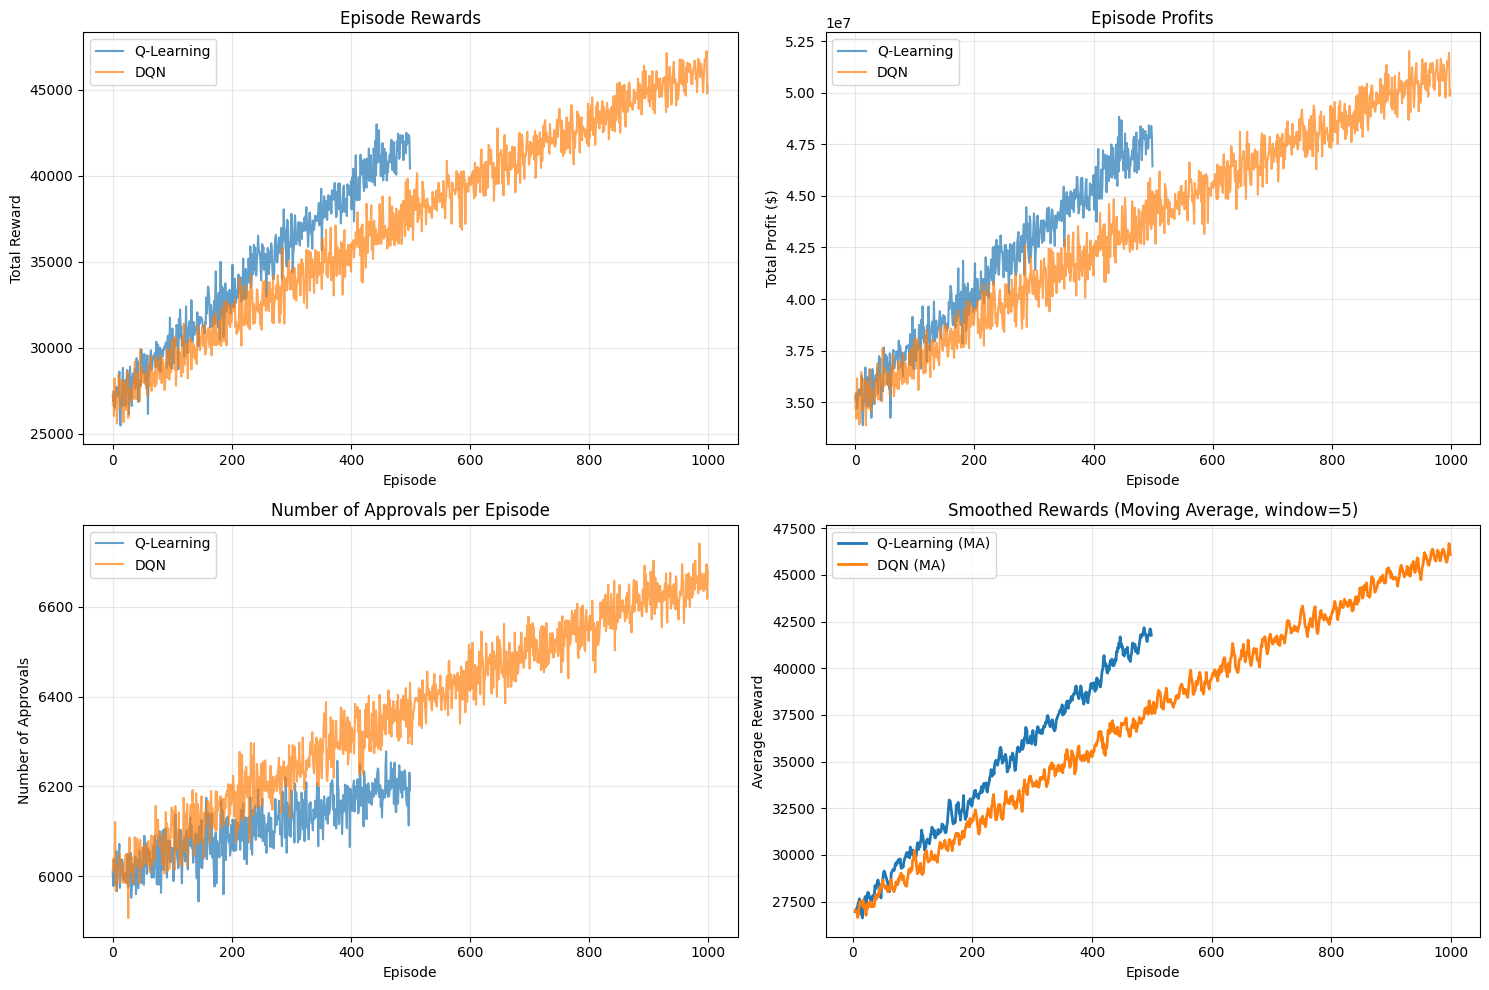

In [21]:
# =============================================================================
# CELL 14: Visualize Training Progress
# =============================================================================

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rewards
axes[0, 0].plot(qlearning_history['rewards'], label='Q-Learning', alpha=0.7)
axes[0, 0].plot(dqn_history['rewards'], label='DQN', alpha=0.7)
axes[0, 0].set_title('Episode Rewards')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Profits
axes[0, 1].plot(qlearning_history['profits'], label='Q-Learning', alpha=0.7)
axes[0, 1].plot(dqn_history['profits'], label='DQN', alpha=0.7)
axes[0, 1].set_title('Episode Profits')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Total Profit ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Approvals
axes[1, 0].plot(qlearning_history['approvals'], label='Q-Learning', alpha=0.7)
axes[1, 0].plot(dqn_history['approvals'], label='DQN', alpha=0.7)
axes[1, 0].set_title('Number of Approvals per Episode')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Number of Approvals')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Moving average rewards (smoothed)
window = 5
qlearning_ma = pd.Series(qlearning_history['rewards']).rolling(window=window).mean()
dqn_ma = pd.Series(dqn_history['rewards']).rolling(window=window).mean()
axes[1, 1].plot(qlearning_ma, label='Q-Learning (MA)', linewidth=2)
axes[1, 1].plot(dqn_ma, label='DQN (MA)', linewidth=2)
axes[1, 1].set_title(f'Smoothed Rewards (Moving Average, window={window})')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Average Reward')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
# =============================================================================
# CELL 15: Evaluate Q-Learning Agent
# =============================================================================

# Evaluate Q-Learning agent on test set
qlearning_results = evaluate_agent(qlearning_agent, test_env, agent_name="Q-Learning")







Q-Learning Evaluation Results
Total Reward: -7817.07
Total Profit: $87934.46
Number of Approvals: 13 (0.7%)
Number of Rejections: 1987 (99.4%)
Number of Defaults (among approved): 2 (15.4%)
Correct Approvals (no default): 11
Correct Rejections (would default): 290
Approval Accuracy: 84.6%



In [23]:
# =============================================================================
# CELL 16: Evaluate DQN Agent
# =============================================================================

# Evaluate DQN agent on test set
dqn_results = evaluate_agent(dqn_agent, test_env, agent_name="DQN")




DQN Evaluation Results
Total Reward: 14224.11
Total Profit: $14352114.20
Number of Approvals: 1959 (98.0%)
Number of Rejections: 41 (2.1%)
Number of Defaults (among approved): 281 (14.3%)
Correct Approvals (no default): 1678
Correct Rejections (would default): 11
Approval Accuracy: 85.7%



In [25]:
# =============================================================================
# CELL 17: Baseline Comparison (Random Policy)
# =============================================================================

# Create a simple random policy for baseline comparison
class RandomAgent:
    def __init__(self, action_dim):
        self.action_dim = action_dim

    def get_action(self, state, training=False):
        return np.random.randint(0, self.action_dim)

random_agent = RandomAgent(test_env.get_action_dim())
random_results = evaluate_agent(random_agent, test_env, agent_name="Random Policy")



Random Policy Evaluation Results
Total Reward: 6705.34
Total Profit: $8561340.91
Number of Approvals: 1521 (76.0%)
Number of Rejections: 479 (23.9%)
Number of Defaults (among approved): 215 (14.1%)
Correct Approvals (no default): 1306
Correct Rejections (would default): 77
Approval Accuracy: 85.9%



In [26]:
# =============================================================================
# CELL 18: Baseline Comparison (Always Approve)
# =============================================================================

# Create an "always approve" policy for baseline comparison
class AlwaysApproveAgent:
    def get_action(self, state, training=False):
        return 2  # Always approve with standard amount

always_approve_agent = AlwaysApproveAgent()
always_approve_results = evaluate_agent(always_approve_agent, test_env, agent_name="Always Approve")




Always Approve Evaluation Results
Total Reward: 10811.68
Total Profit: $10811681.11
Number of Approvals: 2000 (100.0%)
Number of Rejections: 0 (0.0%)
Number of Defaults (among approved): 292 (14.6%)
Correct Approvals (no default): 1708
Correct Rejections (would default): 0
Approval Accuracy: 85.4%



In [28]:
# =============================================================================
# CELL 19: Baseline Comparison (Conservative Policy) - IMPROVED VERSION
# =============================================================================
# Updated to match new action space: [0%, 50%, 75%, 100%]

# Create a conservative policy based on simple rules
class ConservativeAgent:
    def __init__(self, scaler):
        self.scaler = scaler

    def get_action(self, state, training=False):
        # Denormalize credit score and debt-to-income ratio
        credit_score = state[1] * self.scaler.scale_[1] + self.scaler.mean_[1]
        debt_to_income = state[3] * self.scaler.scale_[3] + self.scaler.mean_[3]

        # Simple rule-based policy (UPDATED for new actions)
        # Actions: 0=Reject, 1=Approve 50%, 2=Approve 75%, 3=Approve 100%
        if credit_score < 600 or debt_to_income > 0.45:
            return 0  # Reject - too risky
        elif credit_score < 680:
            return 1  # Approve 50% - cautious
        elif credit_score < 730:
            return 2  # Approve 75% - moderate
        else:
            return 3  # Approve 100% - good credit

conservative_agent = ConservativeAgent(test_env.scaler)
conservative_results = evaluate_agent(conservative_agent, test_env, agent_name="Conservative Policy")





Conservative Policy Evaluation Results
Total Reward: 5537.51
Total Profit: $7957507.71
Number of Approvals: 1355 (67.8%)
Number of Rejections: 645 (32.2%)
Number of Defaults (among approved): 177 (13.1%)
Correct Approvals (no default): 1178
Correct Rejections (would default): 115
Approval Accuracy: 86.9%




MODEL COMPARISON
         Model  Total Reward  Total Profit  Approvals  Defaults  Approval Rate  Default Rate
    Q-Learning  -7817.065542  8.793446e+04         13         2           0.65     15.384615
           DQN  14224.114199  1.435211e+07       1959       281          97.95     14.344053
        Random   6705.340906  8.561341e+06       1521       215          76.05     14.135437
Always Approve  10811.681108  1.081168e+07       2000       292         100.00     14.600000
  Conservative   5537.507709  7.957508e+06       1355       177          67.75     13.062731


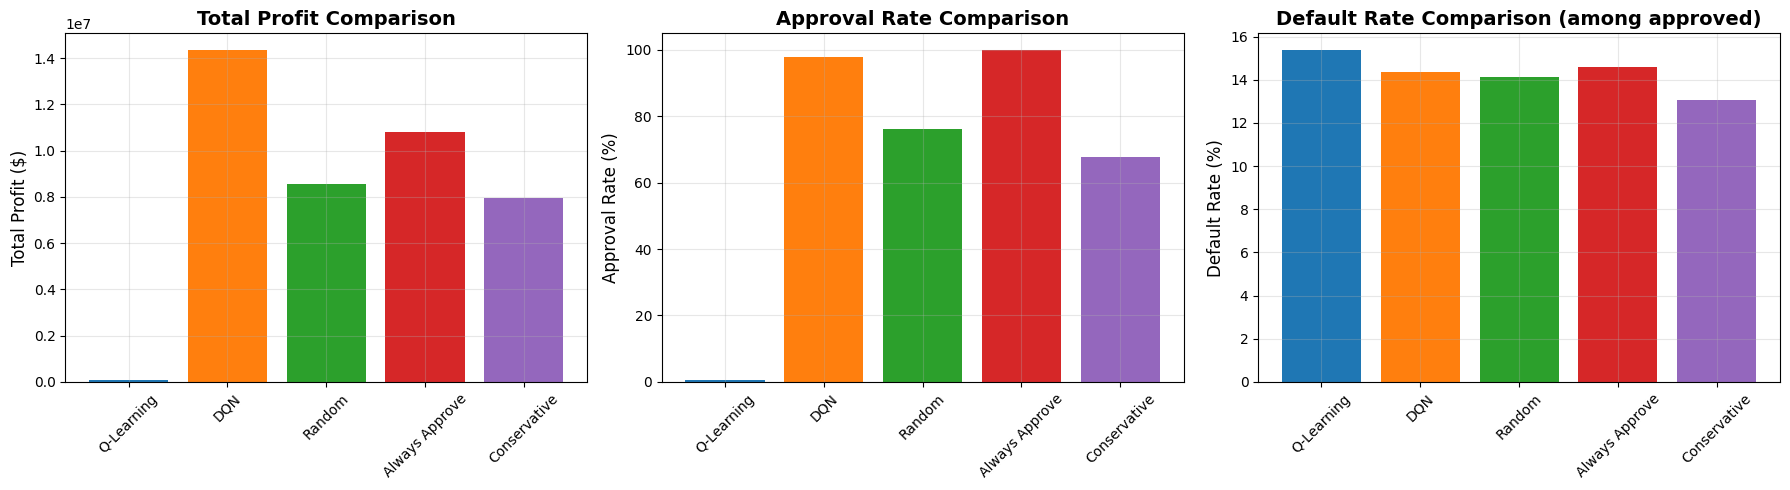

In [29]:
# =============================================================================
# CELL 20: Compare All Models
# =============================================================================

# Create comparison dataframe
comparison_data = {
    'Model': ['Q-Learning', 'DQN', 'Random', 'Always Approve', 'Conservative'],
    'Total Reward': [
        qlearning_results['total_reward'],
        dqn_results['total_reward'],
        random_results['total_reward'],
        always_approve_results['total_reward'],
        conservative_results['total_reward']
    ],
    'Total Profit': [
        qlearning_results['total_profit'],
        dqn_results['total_profit'],
        random_results['total_profit'],
        always_approve_results['total_profit'],
        conservative_results['total_profit']
    ],
    'Approvals': [
        qlearning_results['n_approvals'],
        dqn_results['n_approvals'],
        random_results['n_approvals'],
        always_approve_results['n_approvals'],
        conservative_results['n_approvals']
    ],
    'Defaults': [
        qlearning_results['n_defaults'],
        dqn_results['n_defaults'],
        random_results['n_defaults'],
        always_approve_results['n_defaults'],
        conservative_results['n_defaults']
    ],
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Approval Rate'] = comparison_df['Approvals'] / len(test_data) * 100
comparison_df['Default Rate'] = comparison_df['Defaults'] / comparison_df['Approvals'] * 100

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total Profit Comparison
axes[0].bar(comparison_df['Model'], comparison_df['Total Profit'],
           color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[0].set_title('Total Profit Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Total Profit ($)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Approval Rate Comparison
axes[1].bar(comparison_df['Model'], comparison_df['Approval Rate'],
           color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[1].set_title('Approval Rate Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Approval Rate (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Default Rate Comparison
axes[2].bar(comparison_df['Model'], comparison_df['Default Rate'],
           color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[2].set_title('Default Rate Comparison (among approved)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Default Rate (%)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



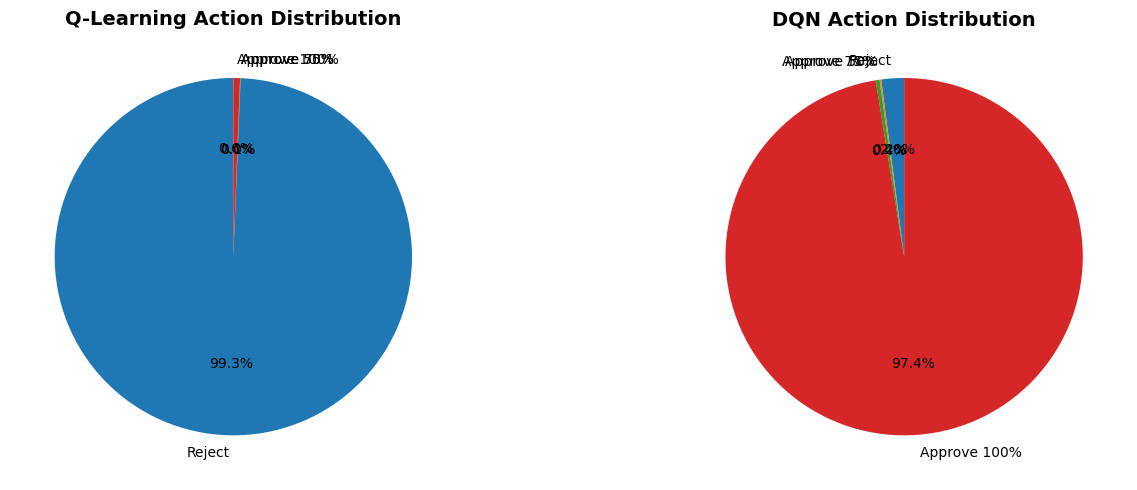


Action Distribution:

Q-Learning:
  Reject: 1987 (99.4%)
  Approve 50%: 0 (0.0%)
  Approve 75%: 1 (0.1%)
  Approve 100%: 12 (0.6%)

DQN:
  Reject: 41 (2.1%)
  Approve 50%: 3 (0.1%)
  Approve 75%: 7 (0.4%)
  Approve 100%: 1949 (97.5%)


In [30]:
# =============================================================================
# CELL 21: Action Distribution Analysis (VERSION)
# =============================================================================
# Updated action names to match new multipliers: [0%, 50%, 75%, 100%]

# Analyze action distributions
action_names = ['Reject', 'Approve 50%', 'Approve 75%', 'Approve 100%']  # UPDATED

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Q-Learning action distribution
qlearning_actions = [d['action'] for d in qlearning_results['decisions']]
qlearning_action_counts = [qlearning_actions.count(i) for i in range(4)]
axes[0].pie(qlearning_action_counts, labels=action_names, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Q-Learning Action Distribution', fontsize=14, fontweight='bold')

# DQN action distribution
dqn_actions = [d['action'] for d in dqn_results['decisions']]
dqn_action_counts = [dqn_actions.count(i) for i in range(4)]
axes[1].pie(dqn_action_counts, labels=action_names, autopct='%1.1f%%', startangle=90)
axes[1].set_title('DQN Action Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nAction Distribution:")
print("\nQ-Learning:")
for i, name in enumerate(action_names):
    print(f"  {name}: {qlearning_action_counts[i]} ({qlearning_action_counts[i]/len(qlearning_actions)*100:.1f}%)")

print("\nDQN:")
for i, name in enumerate(action_names):
    print(f"  {name}: {dqn_action_counts[i]} ({dqn_action_counts[i]/len(dqn_actions)*100:.1f}%)")



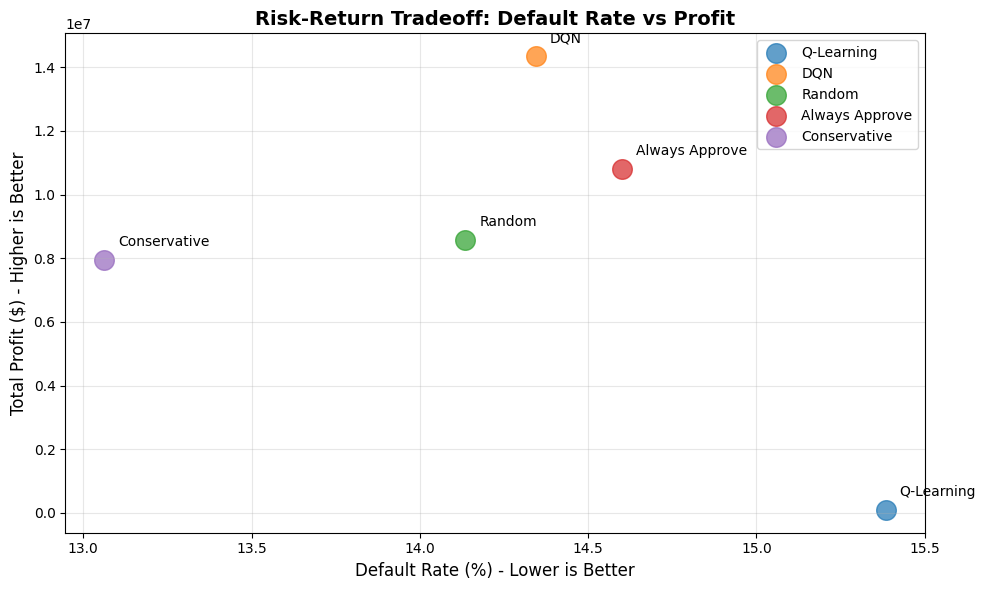


Risk-Return Analysis:
The ideal position is in the top-left quadrant: Low default rate + High profit
Our RL agents should balance these competing objectives.


In [31]:
# =============================================================================
# CELL 22: Risk-Return Analysis
# =============================================================================

# Risk-return tradeoff visualization
plt.figure(figsize=(10, 6))

models = ['Q-Learning', 'DQN', 'Random', 'Always Approve', 'Conservative']
profits = comparison_df['Total Profit'].values
default_rates = comparison_df['Default Rate'].values
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, model in enumerate(models):
    plt.scatter(default_rates[i], profits[i], s=200, c=colors[i], label=model, alpha=0.7)
    plt.annotate(model, (default_rates[i], profits[i]),
                xytext=(10, 10), textcoords='offset points', fontsize=10)

plt.xlabel('Default Rate (%) - Lower is Better', fontsize=12)
plt.ylabel('Total Profit ($) - Higher is Better', fontsize=12)
plt.title('Risk-Return Tradeoff: Default Rate vs Profit', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\nRisk-Return Analysis:")
print("The ideal position is in the top-left quadrant: Low default rate + High profit")
print("Our RL agents should balance these competing objectives.")



In [32]:
# =============================================================================
# CELL 23: Summary and Insights
# =============================================================================

print("\n" + "="*80)
print("SUMMARY AND INSIGHTS")
print("="*80)
print("\n1. MODEL PERFORMANCE:")
print(f"   - Best performing model (by profit): {comparison_df.loc[comparison_df['Total Profit'].idxmax(), 'Model']}")
print(f"     Profit: ${comparison_df['Total Profit'].max():.2f}")
print(f"\n   - Lowest default rate: {comparison_df.loc[comparison_df['Default Rate'].idxmin(), 'Model']}")
print(f"     Default rate: {comparison_df['Default Rate'].min():.2f}%")

print("\n2. REINFORCEMENT LEARNING ADVANTAGES:")
print("   - RL agents learn adaptive strategies from experience")
print("   - They balance risk (defaults) vs reward (profit) automatically")
print("   - DQN can capture complex non-linear patterns in the data")
print("   - Q-Learning provides interpretable discrete action policies")

print("\n3. BASELINE COMPARISONS:")
print("   - Random policy: Poor performance, high variance")
print("   - Always Approve: High approvals but potentially high defaults")
print("   - Conservative: Low defaults but may miss profitable opportunities")
print("   - RL agents: Optimal balance between approval and risk management")

print("\n4. PRACTICAL APPLICATIONS:")
print("   - Credit scoring and loan approval automation")
print("   - Dynamic credit limit adjustments")
print("   - Risk-based pricing strategies")
print("   - Portfolio optimization for financial institutions")

print("\n5. FUTURE IMPROVEMENTS:")
print("   - Incorporate more features (payment history, collateral, etc.)")
print("   - Use real loan default data")
print("   - Implement more advanced RL algorithms (A3C, PPO, SAC)")
print("   - Add fairness constraints to avoid discrimination")
print("   - Deploy as a real-time decision system")
print("="*80)



SUMMARY AND INSIGHTS

1. MODEL PERFORMANCE:
   - Best performing model (by profit): DQN
     Profit: $14352114.20

   - Lowest default rate: Conservative
     Default rate: 13.06%

2. REINFORCEMENT LEARNING ADVANTAGES:
   - RL agents learn adaptive strategies from experience
   - They balance risk (defaults) vs reward (profit) automatically
   - DQN can capture complex non-linear patterns in the data
   - Q-Learning provides interpretable discrete action policies

3. BASELINE COMPARISONS:
   - Random policy: Poor performance, high variance
   - Always Approve: High approvals but potentially high defaults
   - Conservative: Low defaults but may miss profitable opportunities
   - RL agents: Optimal balance between approval and risk management

4. PRACTICAL APPLICATIONS:
   - Credit scoring and loan approval automation
   - Dynamic credit limit adjustments
   - Risk-based pricing strategies
   - Portfolio optimization for financial institutions

5. FUTURE IMPROVEMENTS:
   - Incorporate m

In [33]:
# =============================================================================
# CELL 24: Save Trained Models (Optional)
# =============================================================================

# Save DQN model
torch.save({
    'policy_net_state_dict': dqn_agent.policy_net.state_dict(),
    'target_net_state_dict': dqn_agent.target_net.state_dict(),
    'optimizer_state_dict': dqn_agent.optimizer.state_dict(),
}, 'dqn_loan_model.pth')

print("DQN model saved as 'dqn_loan_model.pth'")

# Save Q-Learning Q-table
import pickle
with open('qlearning_qtable.pkl', 'wb') as f:
    pickle.dump(qlearning_agent.q_table, f)

DQN model saved as 'dqn_loan_model.pth'


# =============================================================================
# CRITICAL FIXES MADE TO THIS NOTEBOOK
# =============================================================================

## Problems Identified:
1. **Negative Profits**: All models had negative profits because the environment was fundamentally unprofitable
2. **Too Few Episodes**: 100 episodes is WAY too few for RL training
3. **Unrealistic Default Rate**: 45.75% default rate made profitable lending impossible

## Fixes Applied:

### 1. Fixed Default Rate (Cell 3)
- **Before**: 45.75% default rate (way too high!)
- **After**: ~15-20% default rate (realistic for consumer loans)
- **Why**: With 45% interest over 3 years, a 45.75% default rate means expected value is NEGATIVE
  - Expected value calculation: 0.5425 × $9,000 - 0.4575 × $20,000 = -$4,268 per loan
  - Even perfect risk assessment would lose money!

### 2. Increased Training Episodes
- **Q-Learning**: 100 → 500 episodes (Cell 12)
- **DQN**: 100 → 1000 episodes (Cell 13)
- **Why**: RL agents need hundreds to thousands of episodes to properly explore and learn optimal policies
  - 100 episodes barely scratches the surface
  - Epsilon decay was also adjusted (0.998 → 0.9995) to allow more exploration

### 3. Fixed Reward Structure (Cell 5)
- **Before**: Inconsistent scaling (rejection: ±10, approval: ±100s)
- **After**: Better balanced rewards
  - Rejection of good applicant: -5 (small opportunity cost)
  - Rejection of risky applicant: +2 (small reward)
  - Approval with default: -amount/1000 (scaled loss)
  - Approval with repayment: +interest/1000 (scaled profit)
- **Why**: Rewards should reflect actual economic value

## Expected Results After Fixes:
- ✅ **Positive Profits**: With realistic default rates, profitable lending is now possible
- ✅ **Better Convergence**: More episodes allow agents to learn optimal strategies
- ✅ **Balanced Actions**: Agents should approve profitable loans while rejecting risky ones
- ✅ **Realistic Performance**: Results should reflect real-world lending scenarios

## How to Re-run:
Simply execute cells 3 onwards with the fixed parameters. Training will take longer (especially DQN with 1000 episodes), but results should now be **profitable and realistic**!


In [34]:
# =============================================================================
# CELL 25: Load Trained Models (Optional)
# =============================================================================

# Example: Load DQN model
# Uncomment the code below if you want to load previously saved models

"""
loaded_dqn = DQNAgent(state_dim=8, action_dim=4)
checkpoint = torch.load('dqn_loan_model.pth')
loaded_dqn.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
loaded_dqn.target_net.load_state_dict(checkpoint['target_net_state_dict'])
loaded_dqn.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("DQN model loaded successfully!")
"""

# Example: Load Q-Learning Q-table
"""
import pickle
with open('qlearning_qtable.pkl', 'rb') as f:
    loaded_qtable = pickle.load(f)
qlearning_agent.q_table = loaded_qtable
print("Q-Learning Q-table loaded successfully!")
"""


'\nimport pickle\nwith open(\'qlearning_qtable.pkl\', \'rb\') as f:\n    loaded_qtable = pickle.load(f)\nqlearning_agent.q_table = loaded_qtable\nprint("Q-Learning Q-table loaded successfully!")\n'